# DSGAN

In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
dataroot = 'data/celeba'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128
image_size = 64 # resize시킬 image_size (raw data는 178 * 218, 파라미터 수의 축소를 위해)
nc = 3 # image_channel
nz = 100 # noise vector의 dimension. generator의 input.

# Size of feature_maps in generator
ngf = 64
ndf = 64
num_epochs = 10

# Adam Optimizer의 parameter
lr = 0.0002
beta1 = 0.5

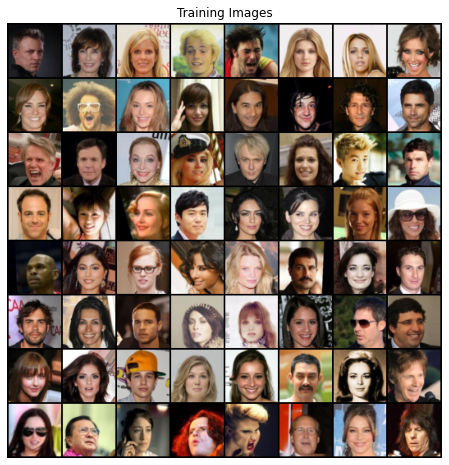

In [3]:
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                               transforms.Resize(image_size), # resize
                               transforms.CenterCrop(image_size), # augmentation
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device('cpu:0')
#device = torch.device('cuda:0')

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding = 2, normalize = True).cpu(),(1, 2, 0)))

In [4]:
device

device(type='cpu', index=0)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # inpue is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False),
            nn.Tanh()
            # Generator의 output Activation은 Tanh. (-1과 1 사이)
            
            # state size. (nc) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

In [6]:
netG = Generator().to(device)

In [7]:
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),
            
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),
            
            # state size. (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            
            # state size. (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
            # Discriminator의 output Activation은 Sigmoid.
            # fake data 인지 아닌지 판별하는 class기 때문에 확률값으로 output이 나와야 함.
        )
        
    def forward(self, input):
        return self.main(input)

In [9]:
netD = Discriminator().to(device)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
criterion = nn.BCELoss() # Loss: Binary Cross Entropy
# 초기 GAN의 Loss.

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device = device) # random으로 noise를 생성.
# noise가 fix된 이유) generator가 학습을 진행할 때마다 fixed된 noise에 대해 어떻게 데이터를 생성하는지를 관찰하기 위해.

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
# 각각 optimizer를 지정.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

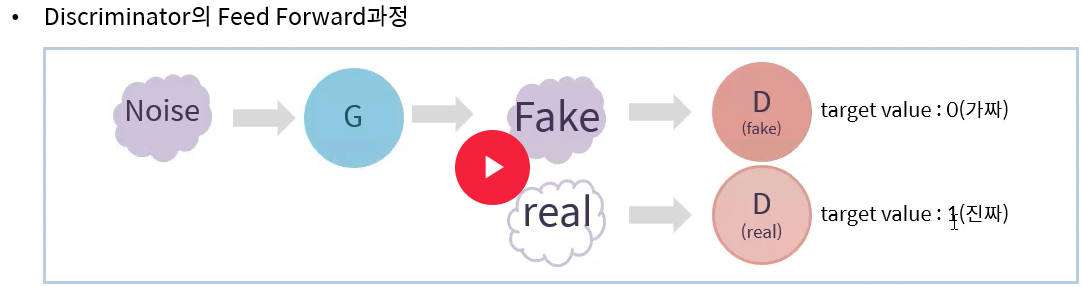

- real data를 D에 feedforward 시킨 후 
    - 이때의 output과 target value(1)를 Loss. (real data에 대한 label을 1로 만듦)
    - D를 BackPropagation.
- Noise를 생성한 후 G에 feedforward 시킨 후
    - 이를 fake data로 만들어 D에 feedforward 시킨 후
    - 이때의 output과 target value(0)를 Loss. (fake data에 대한 label을 0으로 만듦)
    - D를 BackPropagation.

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Starting Training Loop...')
# For each epoch
for epoch in range(num_epochs): # 10번
    # For each batch in the dataloader runtime error: Found dtype Long but expected Float
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        # real data에 대한 D의 학습.
        netD.zero_grad() # Discriminator의 Gradient 초기화.
        # Format batch
        real_cpu = data[0].to(device) # data를 가져옴.
        b_size = real_cpu.size(0) 
        label = torch.full((b_size,), real_label, device=device) # real_label은 1
        output = netD(real_cpu).view(-1) # Discriminator의 output 확률값.
        # output = output.type(torch.FloatTensor)
        errD_real = criterion(output, label) # output과 1의 Loss를 계산.
        errD_real.backward() # Backpropagation 진행.
        D_x = output.mean().item()
        
        # Train with all-fake batch
        # fake data에 대한 D의 학습.
        noise = torch.randn(b_size, nz, 1, 1, device=device) # random한 noise를 생성.
        fake = netG(noise) # Generator에 할당.
        label.fill_(fake_label) # fake data를 0으로 채워줌.
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1) # fake data를 feedforward.
            # output) fake data가 D에 들어갔을 때의 확률값.
            # fake data를 D가 어떻게 생각하는지에 대한 확률값.
        errD_fake = criterion(output, label) # output과 0의 Loss를 계산.
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()
        
        ##############################
        # (2) Update G network: maximize log(D(G(z)))
        ##############################
        netG.zero_grad() # Generator 학습.
        label.fill_(real_label) # fake labels are real for generator cost
        # fake data를 이용해 D를 속여야 하기 때문에 fake data의 label을 1로 설정.
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1) # 이전에 만든 fake data를 D에 넣어 output을 계산.
        # Calculate G's loss based on this output
        errG = criterion(output, label) # 이때의 output과 label (1)을 Loss.
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.apepnd(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval = 1000, repeat_delay = 1000, blit = True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(read_batch[0].to(device)[:64], padding = 5, normalize = True).cpu(),(1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

# LSGAN

In [ ]:
criterion = nn.MSELoss() # MSE를 사용하는 GAN.
netG = Generator().to(device)
netD = Discriminator().to(device)

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))